In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from config import *

In [2]:
def kl_div(distribution, mu, x):
    '''the symbolic expression of kl divergence'''
    if distribution == "Gaussian":
        kl = 1/2*(mu-x)**2
    elif distribution == "Bernoulli":
        kl = mu*np.log(mu/x)+(1-mu)*np.log((1-mu)/(1-x))
    elif distribution == "Poisson":
        kl = mu*np.log(mu/x)-mu+x
    elif distribution == "Gamma":
        kl = np.log(x/mu)-(x-mu)/x
    else:
        raise NotImplementedError
    return kl

In [3]:
def lower_bound(N, DISTRIBUTION, TIME):
    lb_file_name = "./results/{}-{}.npy".format(N, DISTRIBUTION)
    mu_gt = np.load(lb_file_name)

    c = 0
    for i in range(1, len(mu_gt)):
        c = c + (mu_gt[0] - mu_gt[i])/kl_div(DISTRIBUTION, mu_gt[i], mu_gt[0])

    lb = c*np.log(TIME)
    return lb

In [4]:
def record(old_array, record_time, to_be_record, baseline, n, distribution, prob):
    for t,v in zip(record_time, to_be_record):
        if old_array is None:
            old_array = np.array([baseline, n, distribution, prob, t, v])
        else:
            old_array = np.vstack((old_array, np.array([baseline, n, distribution, prob, t, v])))
    return old_array

In [5]:
def load_avg(BASELINE, N, DISTRIBUTION, PROB):
    formatt = "{}-{}-{}-{}".format(BASELINE, N, DISTRIBUTION, round(PROB, 2))
    data = np.zeros(int(T/PERIOD))
    files = os.listdir("./results/")
    c = 0
    for file in files:
        if file.startswith(formatt):
            data_t = np.load(os.path.join("./results", file))
            data = data +data_t
            c = c+1
    print(BASELINE, N, DISTRIBUTION, PROB,c)
    return data/c

In [6]:
record_time = np.zeros(int(T/PERIOD))
for t in range(1, T+1):
    if t % PERIOD == 0:
        record_time[int(t/PERIOD)-1] = t

In [21]:
N = 50
DISTRIBUTION = "Gamma"

TS 50 Gamma 1.0 1000
TSGreedy 50 Gamma 0.02 1000
TSGreedy 50 Gamma 0.14 1000
KL_UCB 50 Gamma 1.0 200
KL_UCB_plus_plus 50 Gamma 1.0 200
ExpTS 50 Gamma 1.0 49
ExpTS_plus 50 Gamma 0.02 50
ExpTS_plus 50 Gamma 0.14 49


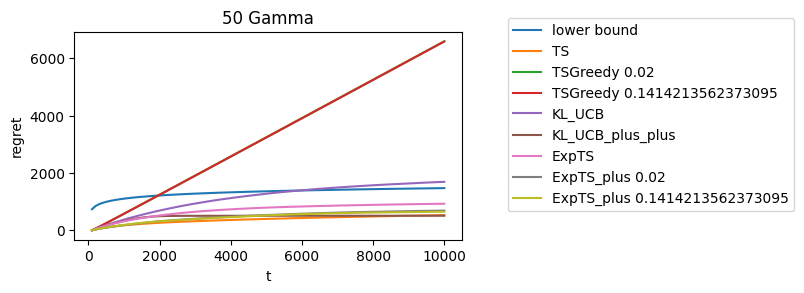

In [22]:
# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(record_time, lower_bound(N, DISTRIBUTION, record_time), label="lower bound")
for BASELINE in BASELINES:
    all_data = record(None, record_time, lower_bound(N, DISTRIBUTION, record_time), BASELINE, N, DISTRIBUTION, 1.0)
    if BASELINE == "MOTS":
        if DISTRIBUTION in ["Gamma", "Poisson"]:
            continue
    if BASELINE in ["TSGreedy", "ExpTS_plus"]:
        for PROB in PROBS_fn(N):
            # avg def
            data = load_avg(BASELINE, N, DISTRIBUTION, round(PROB, 2))
            ax.plot(record_time, data, label="{} {}".format(BASELINE, PROB))
    else:
        data = load_avg(BASELINE, N, DISTRIBUTION, 1.0)
        ax.plot(record_time, data, label="{}".format(BASELINE))
ax.set_xlabel('t')  # Add an x-label to the axes.
ax.set_ylabel('regret')  # Add a y-label to the axes.
ax.set_title("{} {}".format(N, DISTRIBUTION))  # Add a title to the axes.
ax.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)  # Add a legend.

In [ ]:
for N in Ns:
    for DISTRIBUTION in DISTRIBUTIONS:
        for BASELINE in BASELINES:
            all_data = record(None, record_time, lower_bound(N, DISTRIBUTION, record_time), BASELINE, N, DISTRIBUTION, 1.0)
            if BASELINE == "MOTS":
                if DISTRIBUTION in ["Gamma", "Poisson"]:
                    continue
            if BASELINE in ["TSGreedy", "ExpTS_plus"]:
                for PROB in PROBS_fn(N):
                    # avg def
                    data = load_avg(BASELINE, N, DISTRIBUTION, round(PROB, 2))
                    all_data = record(all_data, record_time, data, BASELINE, N, DISTRIBUTION, PROB)
            else:
                data = load_avg(BASELINE, N, DISTRIBUTION, 1.0)
                all_data = record(all_data, record_time, data, BASELINE, N, DISTRIBUTION, 1.0)

/tmp/ipykernel_38859/3791063924.py:11: RuntimeWarning: invalid value encountered in divide
  return data/c


In [ ]:
eval_path = "./results/results.xlsx"
col = np.array(["baseline", "n", "distribution", "prob", "t", "eval"])
df = pd.DataFrame(all_data, columns=col)
df.to_excel(eval_path)

In [ ]:
# read results
eval_path = "./results/results.xlsx"
df = pd.read_excel(eval_path, index_col=0, dtype={"baseline":str, "n":int, "distribution":str, "prob":float, "t":int, "eval":float})

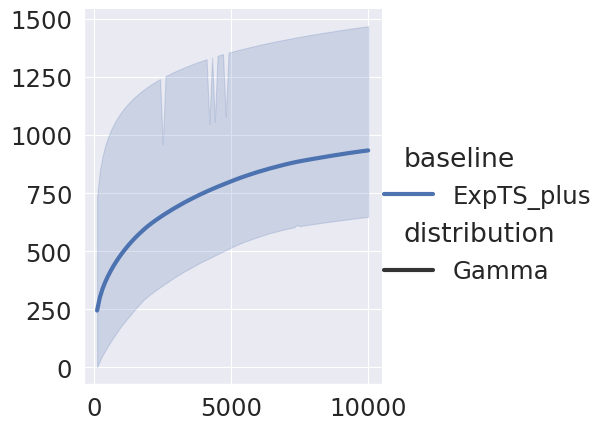

In [ ]:
# "baseline", "n", "dataset", "distribution", "prob", "t", "eval"
df_eval = df[(df.n==50)&(df.distribution=="Gamma")]
pal20c = sns.color_palette('tab20c', 20)
sns.set_theme()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 3}) 
fg = sns.relplot(data=df_eval, x="t", y="eval", hue="baseline", style = "distribution", kind="line", legend="full")
# fg = sns.lineplot(data=df_eval, x="iter", y="eval", hue="dataset", hue_order=["mnist","fmnist","cifar10"], style="method", style_order=["Random", "DVI", "TimeVis"], legend="full")
# sns.move_legend(fg, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
fg.set(xlabel='', ylabel='')

fg.figure.savefig(
    "./results/n_50.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.0,
    transparent=True,
)

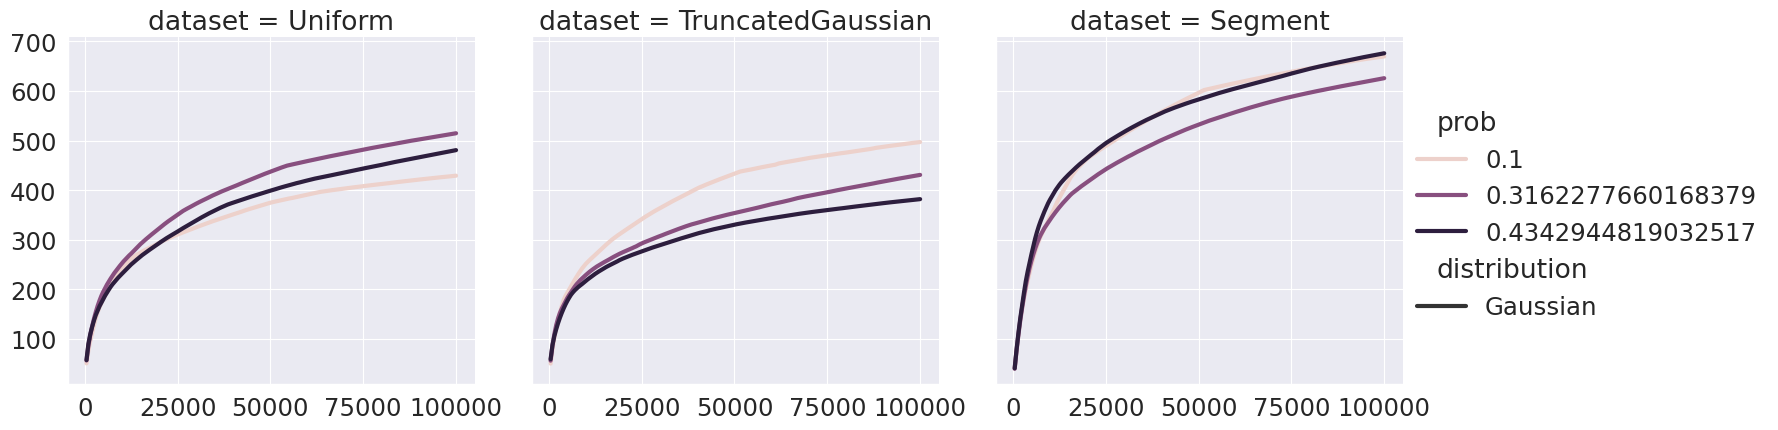

In [ ]:
# "baseline", "n", "dataset", "distribution", "prob", "t", "eval"
df_eval = df[(df.n==10)&(df.baseline=="TSGreedy")&(df.distribution=="Gaussian")]
pal20c = sns.color_palette('tab20c', 20)
sns.set_theme()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 3}) 
fg = sns.relplot(data=df_eval, x="t", y="eval", col="dataset", hue="prob", style = "distribution", kind="line", legend="full")
# fg = sns.lineplot(data=df_eval, x="iter", y="eval", hue="dataset", hue_order=["mnist","fmnist","cifar10"], style="method", style_order=["Random", "DVI", "TimeVis"], legend="full")
# sns.move_legend(fg, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)
fg.set(xlabel='', ylabel='')

fg.figure.savefig(
    "./results/n_10_TSGreedy.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.0,
    transparent=True,
)